In [17]:
!pwd

/content


In [18]:
!ls

data  deeplearning_model.py  __pycache__  sample_data


# CNN卷积神经网络

In [31]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(train_dataset[0])
train_dataset[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x79956AE2C690>, 9)


# 加载数据并处理为tensor格式

In [41]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称标签
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


In [42]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset,
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")

训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [22]:
# 计算训练集均值和方差，以便加载数据集时直接标准化
def calculate_mean_std(train_dataset):
    # 首先将所有图像数据堆叠为一个大张量
    all_images = torch.stack([img_tensor for img_tensor, _ in train_dataset])
    print(all_images.shape)
    # 计算通道维度上的均值和标准差
    # Fashion MNIST是灰度图像，只有一个通道
    # 对所有像素值计算均值和标准差
    mean = torch.mean(all_images)
    std = torch.std(all_images)

    print(f"训练数据集均值: {mean.item():.4f}")
    print(f"训练数据集标准差: {std.item():.4f}")

    # 检查数据集大小
    print(f"数据集中图像总数: {len(train_dataset)}")

calculate_mean_std(train_dataset)

torch.Size([60000, 1, 28, 28])
训练数据集均值: 0.2860
训练数据集标准差: 0.3530
数据集中图像总数: 60000


# 定义CNN模型类

In [23]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.transforms as transforms
from  torchvision.transforms import Normalize

class CNN(nn.Module):
    def __init__(self):
        """
        CNN卷积神经网络模型
        卷积核数量由32依次递增
        使用Xavier均匀分布初始化权重
        """
        super().__init__()
        # 也可以使用固定的均值和标准差进行标准化
        self.normalize = nn.Sequential(Normalize(mean=0.2860, std=0.3530))

        # 标准化层，将输入数据标准化为均值0，标准差1
        # nn.BatchNorm2d(1, affine=False)  # 对单通道灰度图像进行标准化
        # 也可以使用固定的均值和标准差进行标准化

        # 第一个卷积块
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 输入通道1，输出通道32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 输入通道1，输出通道32

        # 池化层，最大值与平均值池化在调参时分别倾向于提取特征和保留特征
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化层

        # 第二个卷积块
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 输入通道32，输出通道64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 输入通道64，输出通道64

        # 第三个卷积块
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 输入通道64，输出通道128
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # 输入通道128，输出通道128

        # 全连接层
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # 全连接层
        self.dropout = nn.Dropout(0.2)  # dropout层防止过拟合
        self.fc2 = nn.Linear(512, 10)  # 输出10个类别

        # 初始化权重
        self._initialize_weights()

    def forward(self, x):
        """
        前向传播
        """
        # 第一个卷积块
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # 卷积->ReLU激活->池化

        # 第二个卷积块
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))  # 卷积->ReLU激活->池化

        # 第三个卷积块
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))  # 卷积->ReLU激活->池化

        # 展平
        x = x.view(-1, 128 * 3 * 3)  # 展平为一维向量x.size(0)

        # 全连接层
        x = F.relu(self.fc1(x))  # 全连接->ReLU激活
        x = self.dropout(x)  # dropout
        x = self.fc2(x)  # 输出层
        return x

    def _initialize_weights(self):
        """
        使用Xavier均匀分布初始化权重
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # 卷积层使用Xavier均匀分布初始化
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # 全连接层使用Xavier均匀分布初始化
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)


In [24]:
# 实例化模型
model = CNN()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)

print(outputs.shape)

批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [25]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 881898
模型总参数量: 881898

各层参数量明细:
conv1.weight: 288 参数
conv1.bias: 32 参数
conv2.weight: 9216 参数
conv2.bias: 32 参数
conv3.weight: 18432 参数
conv3.bias: 64 参数
conv4.weight: 36864 参数
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 589824 参数
fc1.bias: 512 参数
fc2.weight: 5120 参数
fc2.bias: 10 参数


# 设置交叉熵损失函数，SGD优化器

In [26]:
model = CNN()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
# 用少量样本就能更新权重，训练更快，且更容易跳出局部最优,动量为0.9的含义指，当前的梯度是上一次的梯度乘以0.9加上当前的梯度乘以0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #如果GPU可用，则使用GPU，否则使用CPU
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU与训练模型，评估模型，保存模型中相同
early_stopping=EarlyStopping(patience=5, delta=0.005)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver,eval_step=500)


使用设备: cuda:0
训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

早停触发!
90.5000
早停: 在22000 步


In [28]:
history['val'][-20:-1]

[{'loss': 0.2965325319766998, 'acc': 88.84, 'step': 12500},
 {'loss': 0.29657578399181367, 'acc': 88.96, 'step': 13000},
 {'loss': 0.28691961913108827, 'acc': 89.26, 'step': 13500},
 {'loss': 0.300902394759655, 'acc': 88.94, 'step': 14000},
 {'loss': 0.2831677755355835, 'acc': 89.48, 'step': 14500},
 {'loss': 0.2826060162305832, 'acc': 89.54, 'step': 15000},
 {'loss': 0.28077972559928893, 'acc': 89.86, 'step': 15500},
 {'loss': 0.2825756584405899, 'acc': 89.34, 'step': 16000},
 {'loss': 0.284280769610405, 'acc': 89.76, 'step': 16500},
 {'loss': 0.27590565547943113, 'acc': 90.1, 'step': 17000},
 {'loss': 0.27276623077392576, 'acc': 89.88, 'step': 17500},
 {'loss': 0.2674396544456482, 'acc': 90.36, 'step': 18000},
 {'loss': 0.2807819659590721, 'acc': 89.66, 'step': 18500},
 {'loss': 0.2751518964290619, 'acc': 89.86, 'step': 19000},
 {'loss': 0.26058783268928526, 'acc': 90.5, 'step': 19500},
 {'loss': 0.276428786277771, 'acc': 89.78, 'step': 20000},
 {'loss': 0.2609082577943802, 'acc': 90

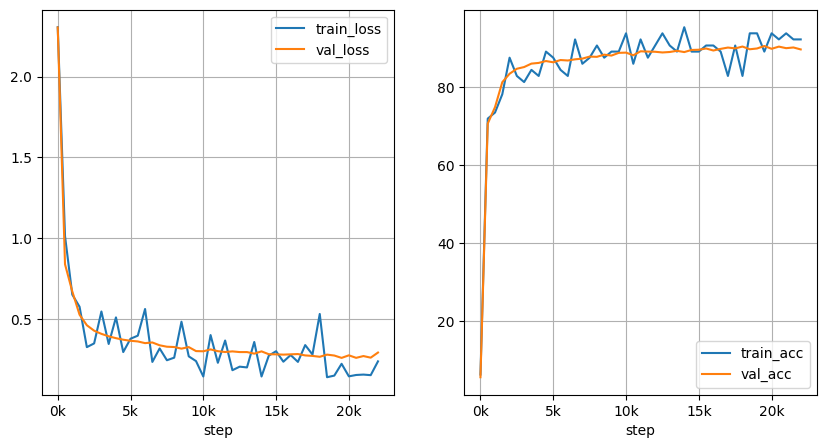

In [29]:
# 绘制学习损失曲线，sample_step是每500步绘制一次
plot_learning_curves(history, sample_step=500)  #横坐标是 steps，纵坐标是 loss，accuracy

In [43]:
# 在测试集上评估模型
test_accuracy = evaluate_classification_model(model, test_loader, device)
test_accuracy

(89.5, None)